# Feature Engineering

1. Generate new features for your dataset and improve model results.
2. Obligatorily features:
    - Dimensinality reduction
    - Target encoding
    - Domain knowledge based on your task
    - Features interactions
3. Remove useless features and show what features have the bigest impact.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import xgbfir
import umap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from collections import Counter

from zipfile import ZipFile

from eli5 import show_weights
from os.path import join as pjoin
from sklearn.decomposition import PCA

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
np.random.seed(24)


Airbnb New User Bookings from https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings. Our task is to predict which country a new user's first booking destination will be.

In [3]:
train = pd.read_csv('./data/airbnb-recruiting/train_users_2.csv')
train.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [3]:
train = train.drop('date_first_booking', axis=1)


In [4]:
target_names = train['country_destination'].unique()
target_names


array(['NDF', 'US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL',
       'DE', 'AU'], dtype=object)

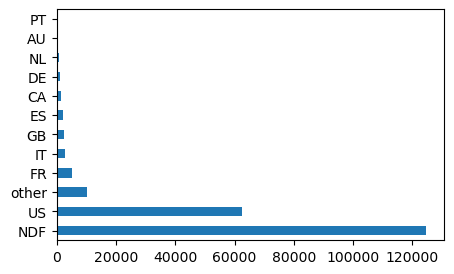

In [6]:
plt.figure(figsize=(5, 3))
train['country_destination'].value_counts().plot(kind='barh');


In [7]:
train['country_destination'].value_counts(normalize=True)


NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [5]:
def get_train_test(df):
    X = df.drop(columns=['country_destination', 'id'])
    y = df['country_destination']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    return X_train, X_test, y_train, y_test


In [6]:
def get_feat_types(df):
    numeric_features = df.select_dtypes('number').columns
    categorical_features = df.select_dtypes('object').columns
    return numeric_features, categorical_features


In [7]:
def get_train_transform(df):
    X_train, X_test, y_train, y_test = get_train_test(df)
    numeric_features, categorical_features = get_feat_types(X_train)


    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
        ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train_transform = preprocessor.fit_transform(X_train)

    y_transformer = LabelEncoder()
    y_train_enc = y_transformer.fit_transform(y_train)

    return X_train_transform, y_train_enc


In [8]:
def get_train_test_transform(df):
    X_train, X_test, y_train, y_test = get_train_test(df)
    numeric_features, categorical_features = get_feat_types(X_train)


    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
        ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train_transform = preprocessor.fit_transform(X_train)
    X_test_transform = preprocessor.transform(X_test)

    y_transformer = LabelEncoder()
    y_train_enc = y_transformer.fit_transform(y_train)
    y_test_enc = y_transformer.transform(y_test)

    return X_train_transform, X_test_transform, y_train_enc, y_test_enc


In [9]:
def make_predict(classifier, preprocessor, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    print(classifier)

    y_pred = pipeline.predict(X_test)
    print("accuracy: ", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    return


In [10]:
num_rounds = 1_000

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}


## Baseline

In [13]:
X_train, X_test, y_train, y_test = get_train_test(train)
numeric_features, categorical_features = get_feat_types(X_train)


In [14]:
#define transformers as pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    ])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=-1))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [15]:
make_predict(ExtraTreesClassifier(random_state=24),
             preprocessor, X_train, y_train, X_test, y_test)


ExtraTreesClassifier(random_state=24)
accuracy:  0.5492726804244454
              precision    recall  f1-score   support

         NDF       0.00      0.00      0.00       101
          US       0.01      0.00      0.00       312
       other       0.01      0.00      0.01       210
          FR       0.01      0.00      0.01       417
          CA       0.04      0.02      0.03      1041
          GB       0.03      0.01      0.02       476
          ES       0.03      0.01      0.02       576
          IT       0.66      0.75      0.70     24853
          PT       0.01      0.01      0.01       143
          NL       0.00      0.00      0.00        42
          DE       0.41      0.38      0.39     12535
          AU       0.06      0.03      0.04      1985

    accuracy                           0.55     42691
   macro avg       0.10      0.10      0.10     42691
weighted avg       0.51      0.55      0.53     42691



In [16]:
X_train_transform, y_train_enc = get_train_transform(train)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=20)


[0]	train-merror:0.41116+0.00052	test-merror:0.41120+0.00084
[20]	train-merror:0.37310+0.00140	test-merror:0.37444+0.00106
[40]	train-merror:0.36797+0.00058	test-merror:0.36966+0.00154
[60]	train-merror:0.36607+0.00102	test-merror:0.36749+0.00106
[80]	train-merror:0.36520+0.00097	test-merror:0.36663+0.00145
[100]	train-merror:0.36434+0.00095	test-merror:0.36629+0.00133
[110]	train-merror:0.36391+0.00107	test-merror:0.36641+0.00156


## Feature Engineering

In [11]:
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_account_created']


0        2010-06-28
1        2011-05-25
2        2010-09-28
3        2011-12-05
4        2010-09-14
            ...    
213446   2014-06-30
213447   2014-06-30
213448   2014-06-30
213449   2014-06-30
213450   2014-06-30
Name: date_account_created, Length: 213451, dtype: datetime64[ns]

In [12]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format='%Y%m%d%H%M%S')
train['timestamp_first_active']


0        2009-03-19 04:32:55
1        2009-05-23 17:48:09
2        2009-06-09 23:12:47
3        2009-10-31 06:01:29
4        2009-12-08 06:11:05
                 ...        
213446   2014-06-30 23:56:36
213447   2014-06-30 23:57:19
213448   2014-06-30 23:57:54
213449   2014-06-30 23:58:22
213450   2014-06-30 23:58:24
Name: timestamp_first_active, Length: 213451, dtype: datetime64[ns]

In [13]:
train['date_account_created_month'] = train['date_account_created'].dt.month
train['date_account_created_weekday'] = train['date_account_created'].dt.weekday
train['date_account_created_hour'] = train['date_account_created'].dt.hour

train['timestamp_first_active_month'] = train['timestamp_first_active'].dt.month
train['timestamp_first_active_weekday'] = train['timestamp_first_active'].dt.weekday
train['timestamp_first_active_hour'] = train['timestamp_first_active'].dt.hour


In [14]:
train.isna().sum()


id                                    0
date_account_created                  0
timestamp_first_active                0
gender                                0
age                               87990
signup_method                         0
signup_flow                           0
language                              0
affiliate_channel                     0
affiliate_provider                    0
first_affiliate_tracked            6065
signup_app                            0
first_device_type                     0
first_browser                         0
country_destination                   0
date_account_created_month            0
date_account_created_weekday          0
date_account_created_hour             0
timestamp_first_active_month          0
timestamp_first_active_weekday        0
timestamp_first_active_hour           0
dtype: int64

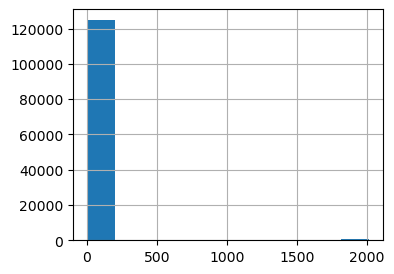

In [21]:
plt.figure(figsize=(4, 3))
train['age'].hist();


In [22]:
train['age'].describe()


count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

Age < 15 and > 100 replace with `np.nan`

In [15]:
train.loc[((train['age'] < 15) | (train['age'] > 100)), 'age'] = np.nan


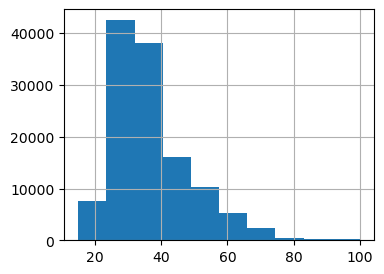

In [24]:
plt.figure(figsize=(4, 3))
train['age'].hist();


In [14]:
train['age'].isna().sum()


90392

In [16]:
print(f"There are {train['age'].isna().sum()/train.shape[0]*100:.2f}% missing value in 'age' column")


There are 42.35% missing value in 'age' column


There are too many missing value in "age" to fill with simple global mean value. Let's try to group some columns to make sure there is enough variation while filling missing values in "age".

In [17]:
train["age"] = train["age"].fillna(
    train.groupby(['gender', 'signup_app'])['age'].transform('mean')
)
train["age"].isna().sum()


0

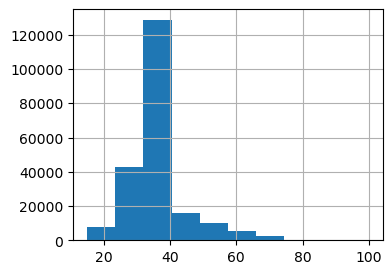

In [18]:
plt.figure(figsize=(4, 3))
train['age'].hist();


In [29]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              213451 non-null  object        
 1   date_account_created            213451 non-null  datetime64[ns]
 2   timestamp_first_active          213451 non-null  datetime64[ns]
 3   gender                          213451 non-null  object        
 4   age                             213451 non-null  float64       
 5   signup_method                   213451 non-null  object        
 6   signup_flow                     213451 non-null  int64         
 7   language                        213451 non-null  object        
 8   affiliate_channel               213451 non-null  object        
 9   affiliate_provider              213451 non-null  object        
 10  first_affiliate_tracked         207386 non-null  object 

In [30]:
X_train_transform, y_train_enc = get_train_transform(train)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=20)


[0]	train-merror:0.39603+0.00187	test-merror:0.39601+0.00236
[20]	train-merror:0.37135+0.00116	test-merror:0.37191+0.00132
[40]	train-merror:0.36839+0.00110	test-merror:0.36951+0.00168
[60]	train-merror:0.36638+0.00104	test-merror:0.36778+0.00158
[80]	train-merror:0.36528+0.00138	test-merror:0.36719+0.00222
[100]	train-merror:0.36440+0.00134	test-merror:0.36688+0.00226
[103]	train-merror:0.36425+0.00133	test-merror:0.36692+0.00233


previuos result:	
- train-merror: 0.36391+0.00107
- test-merror: 0.36641+0.00156

In [20]:
numeric_features, categorical_features = get_feat_types(train)
list(categorical_features)


['id',
 'gender',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [21]:
cat_feats = list(categorical_features)
cat_feats.remove('id')
cat_feats


['gender',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [22]:
for feat in cat_feats:
    print(train[feat].value_counts(dropna=False), '\n')


-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64 

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64 

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
el        24
th        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
Name: language, dtype: int64 

direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64 

direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padm

In [23]:
threshold = int(np.floor(len(train)*0.0005))
threshold


106

Rare categorical values in `affiliate_provider`, `first_browser` and `language` that appear less than the threshold will be removed (convert all values to 'other'). 

In [25]:
for cat in ['affiliate_provider', 'first_browser', 'language']:
    freq = Counter(train[cat])
    other = [i for i in freq if freq[i] < threshold]
    for i in other:
        train[cat].replace(i, 'other', inplace=True)


In [45]:
X_train_transform, y_train_enc = get_train_transform(train)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=20)


[0]	train-merror:0.39606+0.00191	test-merror:0.39605+0.00235
[20]	train-merror:0.37128+0.00111	test-merror:0.37208+0.00142
[40]	train-merror:0.36845+0.00111	test-merror:0.36957+0.00170
[60]	train-merror:0.36624+0.00119	test-merror:0.36788+0.00175
[80]	train-merror:0.36529+0.00125	test-merror:0.36711+0.00221
[100]	train-merror:0.36433+0.00141	test-merror:0.36675+0.00243
[120]	train-merror:0.36353+0.00129	test-merror:0.36650+0.00245
[130]	train-merror:0.36314+0.00130	test-merror:0.36663+0.00245


previuos result:	
- train-merror: 0.36425+0.00133
- test-merror: 0.36692+0.00233

### sessions

In [27]:
with ZipFile('./data/airbnb-recruiting/sessions_csv.zip') as zip_file:
    sessions = pd.read_csv(zip_file.extract('sessions.csv'))


In [33]:
sessions.sample(3)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
8847409,k24r2oe10z,update,submit,update_listing_description,Windows Desktop,37147.0
1112476,spzcmbj9ym,ask_question,submit,contact_host,Mac Desktop,6418.0
490969,4gcpwh6c9n,index,view,message_thread,iPad Tablet,38146.0


In [28]:
# number of session for each user
session_count = sessions.user_id.value_counts().to_frame(name='session_count')
session_count['id'] = session_count.index
session_count.reset_index(drop=True, inplace=True)
session_count


,session_count,id
0,2722,mxqbh3ykxl
1,2644,0hjoc5q8nf
2,2476,mjbl6rrj52
3,2424,l5lgm3w5pc
4,2362,wg9413iaux
...,...,...
135478,1,28ducycdim
135479,1,g09kkvjc6h
135480,1,n02i24pakw
135481,1,ac2u4y37a4


In [29]:
train = train.merge(session_count, how='left', on='id')
train.head(3)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,first_device_type,first_browser,country_destination,date_account_created_month,date_account_created_weekday,date_account_created_hour,timestamp_first_active_month,timestamp_first_active_weekday,timestamp_first_active_hour,session_count
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,Mac Desktop,Chrome,NDF,6,0,0,3,3,4,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,Mac Desktop,Chrome,NDF,5,2,0,5,5,17,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,Windows Desktop,IE,US,9,1,0,6,1,23,NaN


In [30]:
session_total = (sessions.loc[ : , ['user_id', 'secs_elapsed','action']]
    .groupby('user_id')
    .agg(actions_total=('action', 'count'),
         secs_elapsed_total_=('secs_elapsed', 'sum'),
         secs_elapsed_mean=('secs_elapsed', 'mean'),
         secs_elapsed_std=('secs_elapsed', 'std'))
    .fillna(0))
session_total.reset_index(inplace=True)
session_total.rename(columns={'user_id': 'id'}, inplace=True)
session_total.head(3)


,id,actions_total,secs_elapsed_total_,secs_elapsed_mean,secs_elapsed_std
0,00023iyk9l,39,867896.0,22253.743590,92242.561900
1,0010k6l0om,63,586543.0,9460.370968,22751.227918
2,001wyh0pz8,90,282965.0,3179.382022,6569.648182


In [31]:
train = train.merge(session_total, how='left', on='id')
train.head(5)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,date_account_created_weekday,date_account_created_hour,timestamp_first_active_month,timestamp_first_active_weekday,timestamp_first_active_hour,session_count,actions_total,secs_elapsed_total_,secs_elapsed_mean,secs_elapsed_std
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,0,0,3,3,4,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,2,0,5,5,17,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,1,0,6,1,23,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.000000,facebook,0,en,direct,direct,...,0,0,10,5,6,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.000000,basic,0,en,direct,direct,...,1,0,12,1,6,NaN,NaN,NaN,NaN,NaN


In [32]:
action_type = (sessions.groupby(['user_id', 'action_type'])['secs_elapsed']
               .agg(['count', 'sum', 'mean', 'std'])
               .reset_index())
action_type.head()


,user_id,action_type,count,sum,mean,std
0,00023iyk9l,booking_request,1,0.0,0.000000,NaN
1,00023iyk9l,click,4,590691.0,147672.750000,279842.650617
2,00023iyk9l,data,9,7043.0,782.555556,822.214709
3,00023iyk9l,message_post,1,129817.0,129817.000000,NaN
4,00023iyk9l,partner_callback,0,0.0,NaN,NaN


In [33]:
action_type = (action_type
    .pivot(index='user_id', columns='action_type', values=['count', 'sum', 'mean', 'std'])
    .rename(columns={'-unknown-': 'unknown'})
    .reset_index()
    .fillna(0)
)

action_type.head()


user_id   count                                          \
action_type             unknown booking_request booking_response  click   
0            00023iyk9l     0.0             1.0              0.0    4.0   
1            0010k6l0om     5.0             0.0              0.0   16.0   
2            001wyh0pz8     6.0             0.0              0.0   66.0   
3            0028jgx1x1     1.0             0.0              0.0    9.0   
4            002qnbzfs5   184.0             1.0              0.0  140.0   

                                                                ...  \
action_type   data message_post modify partner_callback submit  ...   
0              9.0          1.0    0.0              0.0    0.0  ...   
1              9.0          0.0    0.0              0.0    0.0  ...   
2              2.0          0.0    0.0              0.0    2.0  ...   
3              5.0          0.0    0.0              0.0    0.0  ...   
4            140.0         16.0    0.0              0.0   15.0  ...   

                      std                                                  \
action_type       unknown booking_request booking_response          click   
0                0.000000             0.0              0.0  279842.650617   
1            38683.024511             0.0              0.0    4741.297163   
2             6962.043764             0.0              0.0    3549.168483   
3                0.000000             0.0              0.0   24727.406484   
4            11302.605133             0.0              0.0    6639.180518   

                                                                 \
action_type          data  message_post modify partner_callback   
0              822.214709      0.000000    0.0              0.0   
1            42285.549908      0.000000    0.0              0.0   
2              214.960461      0.000000    0.0              0.0   
3             3672.608514      0.000000    0.0              0.0   
4             4176.363532  26155.224101    0.0              0.0   

                                          
action_type         submit          view  
0                 0.000000  11598.461034  
1                 0.000000  21142.297188  
2             35489.689348   7197.455225  
3                 0.000000  13168.830482  
4            364143.766647   4640.960448  

[5 rows x 41 columns]

In [34]:
action_type.columns = ['action_type_'+'_'.join(col).strip() for col in action_type.columns.values]
action_type.rename(columns={'action_type_user_id_': 'id'}, inplace=True)
action_type.head(3)


,id,action_type_count_unknown,action_type_count_booking_request,action_type_count_booking_response,action_type_count_click,action_type_count_data,action_type_count_message_post,action_type_count_modify,action_type_count_partner_callback,action_type_count_submit,...,action_type_std_unknown,action_type_std_booking_request,action_type_std_booking_response,action_type_std_click,action_type_std_data,action_type_std_message_post,action_type_std_modify,action_type_std_partner_callback,action_type_std_submit,action_type_std_view
0,00023iyk9l,0.0,1.0,0.0,4.0,9.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,279842.650617,822.214709,0.0,0.0,0.0,0.000000,11598.461034
1,0010k6l0om,5.0,0.0,0.0,16.0,9.0,0.0,0.0,0.0,0.0,...,38683.024511,0.0,0.0,4741.297163,42285.549908,0.0,0.0,0.0,0.000000,21142.297188
2,001wyh0pz8,6.0,0.0,0.0,66.0,2.0,0.0,0.0,0.0,2.0,...,6962.043764,0.0,0.0,3549.168483,214.960461,0.0,0.0,0.0,35489.689348,7197.455225


In [35]:
train = train.merge(action_type, how='left', on='id')
train.head(5)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,action_type_std_unknown,action_type_std_booking_request,action_type_std_booking_response,action_type_std_click,action_type_std_data,action_type_std_message_post,action_type_std_modify,action_type_std_partner_callback,action_type_std_submit,action_type_std_view
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.000000,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.000000,basic,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
sessions['device_type'].value_counts(dropna=False)


Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [37]:
device_type = (sessions.groupby(['user_id', 'device_type'])['secs_elapsed']
               .agg(['count', 'mean', 'sum', 'std'])
               .reset_index())

device_type = (device_type
    .pivot(index='user_id', columns='device_type', values=['count', 'sum', 'mean', 'std'])
    .rename(columns={'-unknown-': 'unknown'})
    .reset_index()
    .fillna(0)
)

device_type.columns = ['device_type_'+'_'.join(col).strip().replace(' ', '_') for col in device_type.columns.values]
device_type.rename(columns={'device_type_user_id_': 'id'}, inplace=True)
device_type.head(3)


,id,device_type_count_unknown,device_type_count_Android_App_Unknown_Phone/Tablet,device_type_count_Android_Phone,device_type_count_Blackberry,device_type_count_Chromebook,device_type_count_Linux_Desktop,device_type_count_Mac_Desktop,device_type_count_Opera_Phone,device_type_count_Tablet,...,device_type_std_Chromebook,device_type_std_Linux_Desktop,device_type_std_Mac_Desktop,device_type_std_Opera_Phone,device_type_std_Tablet,device_type_std_Windows_Desktop,device_type_std_Windows_Phone,device_type_std_iPad_Tablet,device_type_std_iPhone,device_type_std_iPodtouch
0,00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,...,0.0,0.0,23300.876660,0.0,0.0,0.0,0.0,0.0,282735.796496,0.0
1,0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,0.0,...,0.0,0.0,22751.227918,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,001wyh0pz8,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [38]:
train = train.merge(device_type, how='left', on='id')
train.head(5)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,device_type_std_Chromebook,device_type_std_Linux_Desktop,device_type_std_Mac_Desktop,device_type_std_Opera_Phone,device_type_std_Tablet,device_type_std_Windows_Desktop,device_type_std_Windows_Phone,device_type_std_iPad_Tablet,device_type_std_iPhone,device_type_std_iPodtouch
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.000000,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.000000,basic,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Columns: 122 entries, id to device_type_std_iPodtouch
dtypes: datetime64[ns](2), float64(102), int64(7), object(11)
memory usage: 200.3+ MB


### Train model

In [41]:
X_train_transform, y_train_enc = get_train_transform(train)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=20)


[0]	train-merror:0.36743+0.00136	test-merror:0.36834+0.00189
[20]	train-merror:0.35841+0.00055	test-merror:0.36004+0.00096
[40]	train-merror:0.35658+0.00037	test-merror:0.35809+0.00131
[60]	train-merror:0.35400+0.00032	test-merror:0.35630+0.00147
[80]	train-merror:0.35208+0.00040	test-merror:0.35506+0.00168
[100]	train-merror:0.35059+0.00077	test-merror:0.35441+0.00150
[120]	train-merror:0.34935+0.00100	test-merror:0.35401+0.00134


previuos result:	
- train-merror: 0.36314+0.0013
- test-merror: 0.36663+0.00245

##  Feature Interactions

In [43]:
model = xgb.train(parameters, xgb_train, num_boost_round=120)


In [44]:
black_list = ['id', 'country_destination']
feature_names = train.select_dtypes(['number', 'object']).columns.to_list()
feature_names = [feat for feat in feature_names if feat not in black_list]


In [45]:
xgbfir.saveXgbFI(
    model,
    feature_names=feature_names,
    OutputXlsxFile=pjoin("./data/airbnb-recruiting", "xgbfir_importance_other.xlsx")
)


device_type_std_Linux_Desktop|gender

device_type_std_Mac_Desktop|gender

device_type_std_Linux_Desktop|device_type_std_Mac_Desktop

action_type_sum_booking_response|device_type_std_Mac_Desktop

action_type_sum_booking_response|gender

gender|timestamp_first_active_month


action_type_sum_booking_response|device_type_std_Linux_Desktop|device_type_std_Mac_Desktop

device_type_std_Mac_Desktop|gender|timestamp_first_active_month

action_type_sum_booking_response|device_type_std_Mac_Desktop|gender


In [20]:
train_fir = train.copy()
train_fir.shape


(213451, 122)

In [21]:
# device_type_std_Linux_Desktop|gender
train_fir['device_type_std_Linux_Desktop|gender'] = (
            (train_fir['device_type_std_Linux_Desktop']
                .apply(lambda x: np.round(x, 0))
                .astype(str))
            + '_'
            + train_fir['gender'])

# device_type_std_Mac_Desktop|gender
train_fir['device_type_std_Mac_Desktop|gender'] = (
            (train_fir['device_type_std_Mac_Desktop']
                .apply(lambda x: np.round(x, 0))
                .astype(str))
            + '_'
            + train_fir['gender'])

# device_type_std_Linux_Desktop|device_type_std_Mac_Desktop
train_fir['device_type_std_Linux_Desktop|device_type_std_Mac_Desktop'] = (
            train_fir['device_type_std_Linux_Desktop']
            + train_fir['device_type_std_Mac_Desktop'])

# action_type_sum_booking_response|device_type_std_Mac_Desktop
train_fir['action_type_sum_booking_response|device_type_std_Mac_Desktop'] = (
            train_fir['action_type_sum_booking_response']
            - train_fir['device_type_std_Mac_Desktop'])

# action_type_sum_booking_response|gender
train_fir['action_type_sum_booking_response|gender'] = (
            train_fir['action_type_sum_booking_response'].astype(str)
            + '_'
            + train_fir['gender'])

# gender|timestamp_first_active_month
train_fir['gender|timestamp_first_active_month'] = (
            train_fir['timestamp_first_active_month'].astype(str)
            + '_'
            + train_fir['gender'])

# action_type_sum_booking_response|device_type_std_Linux_Desktop|device_type_std_Mac_Desktop
train_fir['action_type_sum_booking_response|device_type_std_Linux_Desktop|device_type_std_Mac_Desktop'] = (
            train_fir['action_type_sum_booking_response']
            + train_fir['device_type_std_Linux_Desktop']
            + train_fir['device_type_std_Mac_Desktop'])

# device_type_std_Mac_Desktop|gender|timestamp_first_active_month
train_fir['device_type_std_Mac_Desktop|gender|timestamp_first_active_month'] = (
            ((train_fir['device_type_std_Mac_Desktop'].fillna(-1)
                - train_fir['timestamp_first_active_month'].fillna(-1))
                    .apply(lambda x: np.round(x, 0))
                    .astype(str))
            + '_'
            + train_fir['gender']
            )

# action_type_sum_booking_response|device_type_std_Mac_Desktop|gender
train_fir['action_type_sum_booking_response|device_type_std_Mac_Desktop|gender'] = (
            ((train_fir['action_type_sum_booking_response'].fillna(-1)
                * train_fir['device_type_std_Mac_Desktop'].fillna(-1))
                    .apply(lambda x: np.round(x, 0))
                    .astype(str))
            + '_'
            + train_fir['gender']
            )


In [22]:
X_train_transform, y_train_enc = get_train_transform(train_fir)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=20)


[0]	train-merror:0.39078+0.00065	test-merror:0.39113+0.00087
[20]	train-merror:0.36590+0.00071	test-merror:0.36702+0.00129
[40]	train-merror:0.35667+0.00071	test-merror:0.35793+0.00075
[60]	train-merror:0.35371+0.00040	test-merror:0.35579+0.00085
[80]	train-merror:0.35157+0.00044	test-merror:0.35397+0.00066
[100]	train-merror:0.34991+0.00066	test-merror:0.35351+0.00085
[120]	train-merror:0.34847+0.00082	test-merror:0.35309+0.00088
[134]	train-merror:0.34754+0.00095	test-merror:0.35304+0.00064


previuos result:

- train-merror: 0.34935+0.00100
- test-merror: 0.35401+0.001340

## Target Encoding for gender

In [25]:
train_te = train_fir.copy()


In [26]:
y = train_te['country_destination']
y


0           NDF
1           NDF
2            US
3         other
4            US
          ...  
213446      NDF
213447      NDF
213448      NDF
213449      NDF
213450      NDF
Name: country_destination, Length: 213451, dtype: object

In [27]:
y_enc = LabelEncoder().fit_transform(y)
y_enc


array([ 7,  7, 10, ...,  7,  7,  7])

In [28]:
train_te.drop(
    columns=['date_account_created', 'timestamp_first_active'],
    axis=1, inplace=True)
train_te.head(3)


,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,device_type_std_iPodtouch,device_type_std_Linux_Desktop|gender,device_type_std_Mac_Desktop|gender,device_type_std_Linux_Desktop|device_type_std_Mac_Desktop,action_type_sum_booking_response|device_type_std_Mac_Desktop,action_type_sum_booking_response|gender,gender|timestamp_first_active_month,action_type_sum_booking_response|device_type_std_Linux_Desktop|device_type_std_Mac_Desktop,device_type_std_Mac_Desktop|gender|timestamp_first_active_month,action_type_sum_booking_response|device_type_std_Mac_Desktop|gender
0,gxn3p5htnn,-unknown-,37.303064,facebook,0,en,direct,direct,untracked,Web,...,NaN,nan_-unknown-,nan_-unknown-,NaN,NaN,nan_-unknown-,3_-unknown-,NaN,-4.0_-unknown-,1.0_-unknown-
1,820tgsjxq7,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,...,NaN,nan_MALE,nan_MALE,NaN,NaN,nan_MALE,5_MALE,NaN,-6.0_MALE,1.0_MALE
2,4ft3gnwmtx,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,...,NaN,nan_FEMALE,nan_FEMALE,NaN,NaN,nan_FEMALE,6_FEMALE,NaN,-7.0_FEMALE,1.0_FEMALE


In [29]:
train_te['first_affiliate_tracked'].fillna('unknown', inplace=True)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    train_te,
    y_enc,
    test_size=0.2,
    random_state=24,
    stratify=y
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(170760, 129) (170760,) (42691, 129) (42691,)


In [31]:
class TargetFeatureEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y

        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) /
                (temp['y']['size'] + self.C)
            ).to_dict()

        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data


In [32]:
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = TargetFeatureEncoding()
    new_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split],
            new_train_y[new_train_split],
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val


In [58]:
features = ['gender', 'first_browser', 'signup_method', 'affiliate_channel']


In [59]:
%%time

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(X_train, y_train):
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        X_train.iloc[train_split],
        y_train[train_split],
        X_train.iloc[val_split],
        features
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = TargetFeatureEncoding()
    se.fit(X_train.iloc[train_split], y_train[train_split], features)
    main_train_dfs.append(
        se.transform(X_train.iloc[val_split], inplace=False)
    )

se.fit(X_train, y_train, features=features)
main_test = se.transform(X_test, inplace=False)


CPU times: total: 44.9 s
Wall time: 45.5 s


In [60]:
train_te_new = pd.concat([i for i in main_train_dfs], axis=0, ignore_index=True)


In [61]:
train_te_new = pd.concat([train_te_new, main_test], ignore_index=True)


In [62]:
train_te_new.head(3)


,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,device_type_std_iPodtouch,device_type_std_Linux_Desktop|gender,device_type_std_Mac_Desktop|gender,device_type_std_Linux_Desktop|device_type_std_Mac_Desktop,action_type_sum_booking_response|device_type_std_Mac_Desktop,action_type_sum_booking_response|gender,gender|timestamp_first_active_month,action_type_sum_booking_response|device_type_std_Linux_Desktop|device_type_std_Mac_Desktop,device_type_std_Mac_Desktop|gender|timestamp_first_active_month,action_type_sum_booking_response|device_type_std_Mac_Desktop|gender
0,12s59vmpe6,8.05090,24.000000,7.809707,0,en,7.872403,direct,omg,Web,...,0.000000,0.0_MALE,18221.0_MALE,18221.156819,-18221.156819,0.0_MALE,6_MALE,18221.156819,18215.0_MALE,0.0_MALE
1,475heu4d6t,7.61431,47.000000,7.854900,0,en,7.872403,direct,omg,Web,...,7.841049,nan_-unknown-,nan_-unknown-,7.841049,7.841049,nan_-unknown-,2_-unknown-,7.841049,-3.0_-unknown-,1.0_-unknown-
2,bfq1xv9k96,7.61431,37.303064,7.854900,0,en,7.697582,google,omg,Web,...,0.000000,0.0_-unknown-,42383.0_-unknown-,42382.716887,-42382.716887,0.0_-unknown-,6_-unknown-,42382.716887,42377.0_-unknown-,0.0_-unknown-


In [63]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-merror:0.38591+0.00155	test-merror:0.38629+0.00136
[50]	train-merror:0.35627+0.00098	test-merror:0.35835+0.00140
[100]	train-merror:0.35102+0.00140	test-merror:0.35470+0.00206
[144]	train-merror:0.34842+0.00150	test-merror:0.35409+0.00233


previous result: 

- train-merror: 0.34754+0.00095
- test-merror: 0.35304+0.00064

##  Dimensinality reduction

Let's try to use not important features (with weight=0) by replacing they with one or two features using dimensinality reduction.

In [77]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)


In [78]:
model = xgb.train(parameters, xgb_train, num_boost_round=135)


In [79]:
show_weights(model,
             feature_names=train_te_new.drop(columns=['country_destination', 'id']).columns.values,
             top=200)


Weight,Feature
0.3069,action_type_count_booking_response
0.0435,signup_method
0.0407,action_type_count_modify
0.0404,action_type_sum_booking_response|device_type_std_Mac_Desktop|gender
0.0333,gender
0.0295,action_type_count_unknown
0.0290,age
0.0253,actions_total
0.0169,signup_flow
0.0156,action_type_sum_booking_response|gender


In [28]:
feat_to_drop = [
'device_type_std_Tablet',
'device_type_std_Android_Phone',
'device_type_mean_iPhone',
'action_type_std_booking_request',
'device_type_mean_Tablet',
'device_type_mean_Linux_Desktop',
'device_type_mean_Android_Phone',
'action_type_count_partner_callback',
'action_type_sum_booking_request',
'device_type_sum_Android_Phone',
'device_type_sum_unknown',
'action_type_sum_partner_callback',
'device_type_count_Tablet',
'device_type_count_Linux_Desktop',
'action_type_mean_booking_request',
'device_type_count_Android_Phone',
'action_type_std_view',
'action_type_mean_partner_callback',
'action_type_std_submit']


In [85]:
pca = PCA(n_components=2, random_state=24)
X_reduced = pca.fit_transform(train_te_new[feat_to_drop])
X_reduced


array([[-15044.00218873, -13152.25913571],
       [-15411.17769187, -13780.53235079],
       [-14148.03086797, -11637.91518133],
       ...,
       [-15411.17773778, -13780.53239109],
       [-15411.17773778, -13780.53239109],
       [-15142.31034646, -13318.41664639]])

In [86]:
train_pca = train_te_new.drop(feat_to_drop, axis=1)
train_pca['pca_1'] = X_reduced[:, 0]
train_pca['pca_2'] = X_reduced[:, 1]


In [87]:
X_train_transform, y_train_enc = get_train_transform(train_pca)

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-merror:0.38970+0.00148	test-merror:0.38968+0.00123
[50]	train-merror:0.35599+0.00100	test-merror:0.35739+0.00119
[100]	train-merror:0.35066+0.00129	test-merror:0.35437+0.00207
[147]	train-merror:0.34797+0.00156	test-merror:0.35367+0.00244


previous result: 
- train-merror: 0.34842+0.00150
- test-merror: 0.35409+0.00233

The result has improved a little.

Let try to use PCA with 20 components instead of all features.

In [88]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)

pca = PCA(n_components=20, random_state=24)
X_reduced = pca.fit_transform(X_train_transform)

xgb_train = xgb.DMatrix(X_reduced, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-merror:0.41523+0.00101	test-merror:0.41537+0.00085
[50]	train-merror:0.40670+0.00013	test-merror:0.40847+0.00054
[100]	train-merror:0.40414+0.00021	test-merror:0.40770+0.00059
[131]	train-merror:0.40264+0.00019	test-merror:0.40741+0.00077


The worst result, which was expected.

In [90]:
idx_col_to_drop = [train_te_new.columns.get_loc(col) for col in feat_to_drop]
print(idx_col_to_drop)


[114, 108, 104, 55, 100, 97, 94, 31, 35, 80, 78, 41, 72, 69, 45, 66, 63, 51, 62]


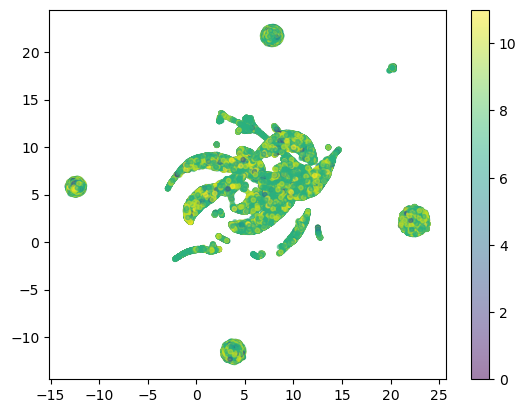

In [91]:
X_embedding_umap = (umap.UMAP(n_neighbors=30, n_jobs=1, random_state=24)
                    .fit_transform(X_train_transform[:, idx_col_to_drop]))

plt.scatter(X_embedding_umap[:, 0], X_embedding_umap[:, 1],
            s=10, c=y_train_enc, alpha=0.5)
plt.colormaps.get_cmap('nipy_spectral')
plt.colorbar()
plt.show()


In [94]:
X_train_umap = np.delete(X_train_transform, idx_col_to_drop, axis=1)
X_train_umap = np.c_[X_train_umap, X_embedding_umap[:, 0], X_embedding_umap[:, 1]]

xgb_train = xgb.DMatrix(X_train_umap, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-merror:0.38809+0.00077	test-merror:0.38832+0.00066
[50]	train-merror:0.35602+0.00103	test-merror:0.35788+0.00149
[100]	train-merror:0.35107+0.00138	test-merror:0.35513+0.00180
[150]	train-merror:0.34809+0.00137	test-merror:0.35411+0.00207
[170]	train-merror:0.34712+0.00122	test-merror:0.35402+0.00221


previous the best result: 

- train-merror: 0.34754+0.00095
- test-merror: 0.35304+0.00064

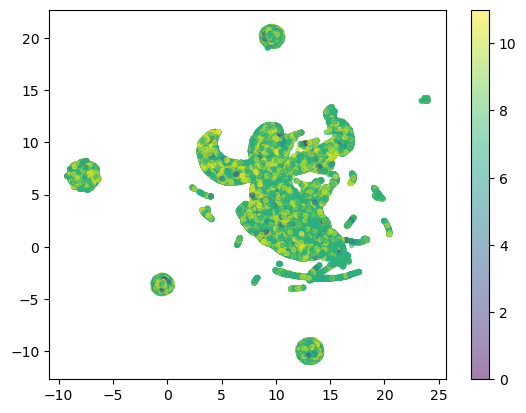

In [95]:
X_embedding_umap = (umap.UMAP(n_neighbors=20, n_jobs=1, random_state=24)
                    .fit_transform(X_train_transform[:, idx_col_to_drop]))

plt.scatter(X_embedding_umap[:, 0], X_embedding_umap[:, 1],
            s=10, c=y_train_enc, alpha=0.5)
plt.colormaps.get_cmap('nipy_spectral')
plt.colorbar()
plt.show()


In [96]:
X_train_umap = np.delete(X_train_transform, idx_col_to_drop, axis=1)
X_train_umap = np.c_[X_train_umap, X_embedding_umap[:, 0], X_embedding_umap[:, 1]]

xgb_train = xgb.DMatrix(X_train_umap, y_train_enc)


results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-merror:0.38809+0.00077	test-merror:0.38832+0.00066
[50]	train-merror:0.35629+0.00100	test-merror:0.35827+0.00164
[100]	train-merror:0.35124+0.00126	test-merror:0.35531+0.00148
[150]	train-merror:0.34831+0.00155	test-merror:0.35443+0.00214
[183]	train-merror:0.34640+0.00144	test-merror:0.35394+0.00228


previous the best result: 

- train-merror: 0.34712+0.00122
- test-merror: 0.35402+0.00221

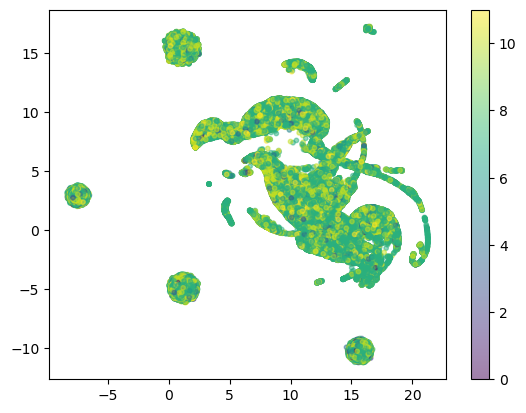

In [97]:
X_embedding_umap = (umap.UMAP(n_neighbors=15, n_jobs=1, random_state=24)
                    .fit_transform(X_train_transform[:, idx_col_to_drop]))

plt.scatter(X_embedding_umap[:, 0], X_embedding_umap[:, 1],
            s=10, c=y_train_enc, alpha=0.5)
plt.colormaps.get_cmap('nipy_spectral')
plt.colorbar()
plt.show()


In [98]:
X_train_umap = np.delete(X_train_transform, idx_col_to_drop, axis=1)
X_train_umap = np.c_[X_train_umap, X_embedding_umap[:, 0], X_embedding_umap[:, 1]]

xgb_train = xgb.DMatrix(X_train_umap, y_train_enc)

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-merror:0.38809+0.00077	test-merror:0.38832+0.00066
[50]	train-merror:0.35614+0.00083	test-merror:0.35827+0.00166
[100]	train-merror:0.35121+0.00151	test-merror:0.35515+0.00163
[141]	train-merror:0.34858+0.00178	test-merror:0.35438+0.00186


previous the best result: 

- train-merror: 0.34640+0.00144
- test-merror: 0.35394+0.00228

### Prediction for the best model

In [13]:
X_train_transform, X_test_transform, y_train_enc, y_test_enc = get_train_test_transform(train_te_new)

embedding_umap = (umap.UMAP(n_neighbors=20, n_jobs=1, random_state=24)
                    .fit(X_train_transform[:, idx_col_to_drop]))

X_train_embedding_umap = embedding_umap.transform(X_train_transform[:, idx_col_to_drop])

X_test_embedding_umap = embedding_umap.transform(X_test_transform[:, idx_col_to_drop])

X_train_umap = np.delete(X_train_transform, idx_col_to_drop, axis=1)
X_train_umap = np.c_[X_train_umap, X_train_embedding_umap[:, 0], X_train_embedding_umap[:, 1]]

X_test_umap = np.delete(X_test_transform, idx_col_to_drop, axis=1)
X_test_umap = np.c_[X_test_umap, X_test_embedding_umap[:, 0], X_test_embedding_umap[:, 1]]

num_rounds = 185

xgb_train = xgb.DMatrix(X_train_umap, y_train_enc)
xgb_test = xgb.DMatrix(X_test_umap, y_test_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

model = xgb.train(parameters, xgb_train, num_rounds)

predict = model.predict(xgb_test)
y_pred = np.argmax(predict, axis=1)
print("accuracy: ", accuracy_score(y_test_enc, y_pred))


d:\anaconda3\envs\projector\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


accuracy:  0.6480757068234523


# Feature importance

In [46]:
feature_names = train_te_new.drop(columns=['country_destination', 'id']).columns.values


In [47]:
FEATURES = {f'f{i}': feature for i, feature in enumerate(feature_names)}


In [57]:
sorted_features_by_gain = sorted(model.get_score(importance_type='gain').items(),
                                 key=lambda item: item[1], reverse=True)

for feature, gain in sorted_features_by_gain:
    print(f"{FEATURES[feature]:60}: {gain:.3f}")


action_type_count_unknown                                   : 40.470
gender                                                      : 37.280
action_type_count_modify                                    : 34.593
signup_method                                               : 32.613
device_type_std_unknown                                     : 31.586
age                                                         : 29.675
actions_total                                               : 17.143
signup_flow                                                 : 16.454
action_type_sum_data                                        : 15.243
device_type_mean_Windows_Desktop                            : 12.864
device_type_mean_iPhone                                     : 12.559
action_type_count_view                                      : 12.457
device_type_sum_Windows_Desktop                             : 9.680
affiliate_channel                                           : 9.436
language                            

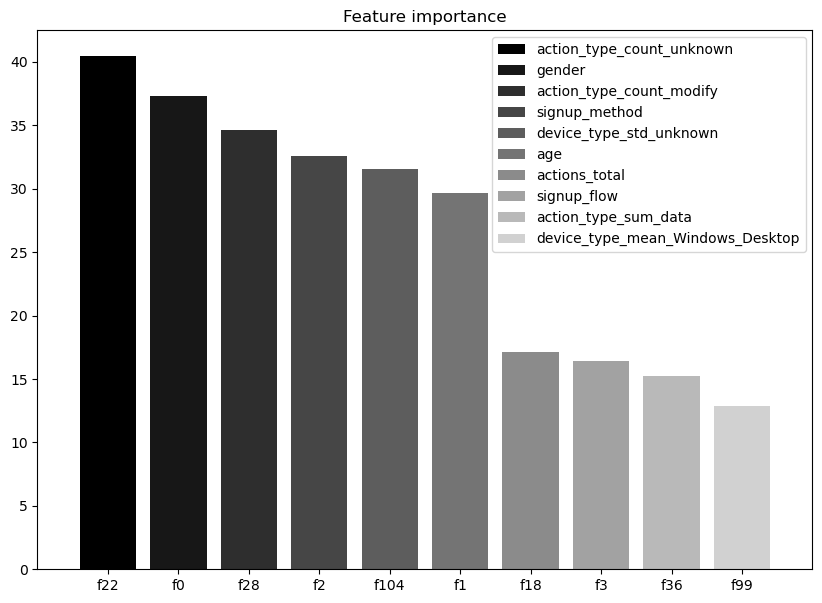

In [58]:
num_to_plot = 10

plt.title(u"Feature importance")

bars = plt.bar(range(num_to_plot),
               [gain for _, gain in sorted_features_by_gain][:num_to_plot],
               color=([str(i/float(num_to_plot+1))
                       for i in range(num_to_plot)]),
               align='center')

ticks = plt.xticks(range(num_to_plot),
                   [feature_name for feature_name, _ in sorted_features_by_gain[:num_to_plot]])

plt.xlim([-1, num_to_plot])

plt.legend(bars,
           [FEATURES[feature_name] for feature_name, _ in sorted_features_by_gain[:num_to_plot]])
plt.show()
